## Analyze Learning Curves

1. Find a comparable checkpoints between two trainings.
    + Either statistically
    + or ...
2. 

In [130]:
import pickle
from scipy import stats
from functools import partial

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

import numpy as np
import nibabel as nib

import torch
import torch.nn.functional as F

from sage.visualization.vistool import plot_vismap
from utils.analysis import (
    Result,
    FileSelector,
    check_existence,
    cherry_picker,
    transform,
)

In [131]:
with open("./data/naive_results_renewal.pkl", "rb") as f:
    # with open("./data/naive_results.pkl", "rb") as f:
    # with open("./data/naive_nonreg_results.pkl", "rb") as f:
    naive_results = pickle.load(f)
    naive_results = {
        e[0]: e[1] for e in sorted(naive_results.items(), key=lambda x: x[0])
    }

with open("./data/augment_results_renewal.pkl", "rb") as f:
    # with open("./data/augment_results.pkl", "rb") as f:
    # with open("./data/augment_nonreg_results.pkl", "rb") as f:
    augment_results = pickle.load(f)
    augment_results = {
        e[0]: e[1] for e in sorted(augment_results.items(), key=lambda x: x[0])
    }

In [132]:
naive = Result(naive_results)
augment = Result(augment_results)

In [133]:
# plt.figure(figsize=(12, 8))
# plt.title("Naive Training MAE Curve")
# plt.xlabel("Epoch")
# plt.ylabel("MAE")
# plt.ylim(0, 100)

# for idx in range(len(naive)):
#     plt.plot(*transform(naive[idx]), alpha=.7)

# plt.show();

In [134]:
# plt.figure(figsize=(12, 8))
# plt.title("Augment Training MAE Curve")
# plt.xlabel("Epoch")
# plt.ylabel("MAE")

# for idx in range(len(augment)):
#     plt.plot(*transform(augment[idx]))

# plt.show();

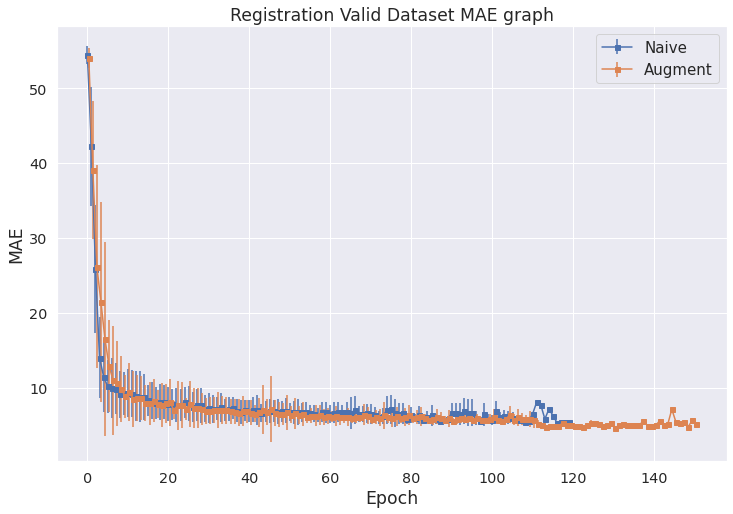

In [136]:
plt.figure(figsize=(12, 8))
plt.title("Registration Valid Dataset MAE graph", size="x-large")
plt.xlabel("Epoch", size="x-large")
plt.ylabel("MAE", size="x-large")
plt.xticks(fontsize="large")
plt.yticks(fontsize="large")
plt.errorbar(
    *map(list, (naive.mean.keys(), naive.mean.values())),
    ms=5,
    marker="s",
    yerr=list(naive.std.values()),
    label="Naive"
)
plt.errorbar(
    np.array(list(augment.mean.keys())) + 0.35,
    list(augment.mean.values()),
    ms=5,
    marker="s",
    yerr=list(augment.std.values()),
    label="Augment",
)
plt.legend(prop={"size": 15})
plt.savefig("figs/reg_valid.png", bbox_inches="tight", pad_inches=0)

In [37]:
last_values_naive = [e[-1][1] for e in naive.raw_data.values()]
last_values_augment = [e[-1][1] for e in augment.raw_data.values()]

stats.ttest_ind(last_values_naive, last_values_augment)

Ttest_indResult(statistic=1.0656010417611546, pvalue=0.28788874914735973)

In [38]:
best_values_naive = [min(_[1] for _ in e) for e in naive.raw_data.values()]
best_values_augment = [min(_[1] for _ in e) for e in augment.raw_data.values()]

stats.ttest_ind(best_values_naive, best_values_augment)

Ttest_indResult(statistic=2.8445420415766764, pvalue=0.00491001596838417)

In [39]:
earlystopped_values_naive = [e[-20][1] for e in naive.raw_data.values()]
earlystopped_values_augment = [e[-20][1] for e in augment.raw_data.values()]

stats.ttest_ind(earlystopped_values_naive, earlystopped_values_augment)

Ttest_indResult(statistic=-0.21833255621830094, pvalue=0.8273926272969039)

In [40]:
total_train_naive = [len(e) for e in naive.raw_data.values()]
total_train_augment = [len(e) for e in augment.raw_data.values()]

stats.ttest_ind(total_train_naive, total_train_augment)

Ttest_indResult(statistic=-4.322801232465882, pvalue=2.427926641072049e-05)

In [41]:
best_indices_naive = [
    sorted(e, key=lambda x: x[1])[0][0] for e in naive.raw_data.values()
]
best_indices_augment = [
    sorted(e, key=lambda x: x[1])[0][0] for e in augment.raw_data.values()
]

stats.ttest_ind(best_indices_naive, best_indices_augment)

Ttest_indResult(statistic=-4.387967308780985, pvalue=1.8503980879789524e-05)

In [9]:
naive_fileselector = FileSelector("naive")
best_maps_naive = np.array(
    list(
        map(
            partial(cherry_picker, selector=naive_fileselector),
            list(
                filter(
                    partial(check_existence, selector=naive_fileselector),
                    zip(range(len(best_indices_naive)), best_indices_naive),
                )
            ),
        )
    )
)

In [10]:
augment_fileselector = FileSelector("augment")
best_maps_augment = np.array(
    list(
        map(
            partial(cherry_picker, selector=augment_fileselector),
            list(
                filter(
                    partial(check_existence, selector=augment_fileselector),
                    zip(range(len(best_indices_augment)), best_indices_augment),
                )
            ),
        )
    )
)

In [11]:
def parser(input, selector):

    fname = selector.get("npy_std/layer0", input[0])[input[1]]
    return " ".join((fname.split("/")[1], fname.split("/")[5]))

In [22]:
meta = list(
    map(
        partial(parser, selector=naive_fileselector),
        zip(range(len(best_indices_naive)), best_indices_naive),
    )
)

In [12]:
def save2nifti(npy, savename, overwrite=False):

    """
    Takes saliency map with shape of (96, 96, 96)
    """
    if npy.ndim == 4:
        print(f"Came across with array dimension of {npy.ndim}, {npy.shape}.")
        print(f"Shrink with average on axis=0")
        npy = np.mean(npy, axis=0)

    # Resize
    resized_nifti = (
        F.interpolate(torch.tensor(npy[None, None, ...]), size=(207, 256, 215))
        .squeeze()
        .squeeze()
        .numpy()
    )

    # Define Affine Matrix
    affine = np.array(
        [
            [0.73746, 0.00000, 0.00000, -75.76254],
            [0.00000, 0.73746, 0.00000, -110.76254],
            [0.00000, 0.00000, 0.73746, -71.76254],
            [0, 0, 0, 0],
        ]
    )

    if os.path.exists(savename):
        if overwrite is False:
            print("File with same name exists, please allow overwrite to replace.")
            return

    nib.save(
        nib.Nifti1Image(
            resized_nifti,
            affine,
        ),
        savename,
    )
    print("Successfully saved.")

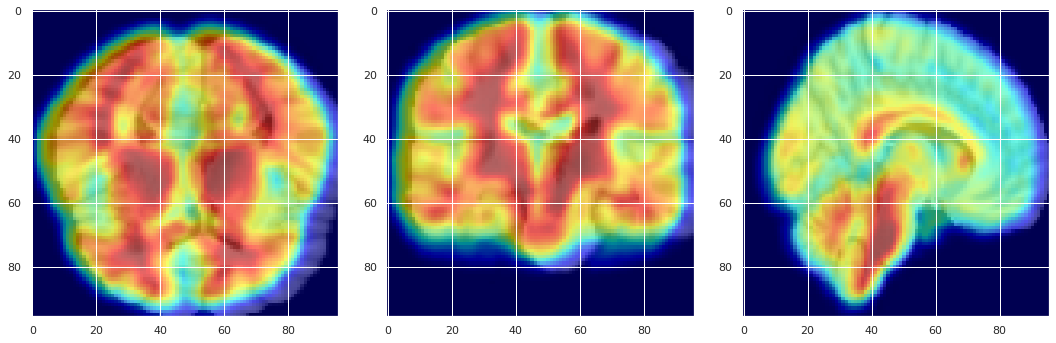

In [134]:
plot_vismap("template", np.mean(best_maps_naive, axis=0), masked=False);

In [13]:
def create_agreement(maps, thrshold_count):

    thrsh = maps.copy()
    for idx, npy in enumerate(maps):
        thresholded = npy > np.quantile(npy, 0.99)
        thrsh[idx] = thresholded

    agreement = (
        thrsh.sum(axis=0) > thrshold_count
    )  # sum up counts. (96, 96, 96) brain with counts
    print(agreement.shape)

    # agreement = agreement > thrshold_count # boolean of thrshold count, above or not
    final_map = (maps.copy() * agreement).sum(axis=0)  # count all voxels
    plot_vismap("template", final_map, masked=False);

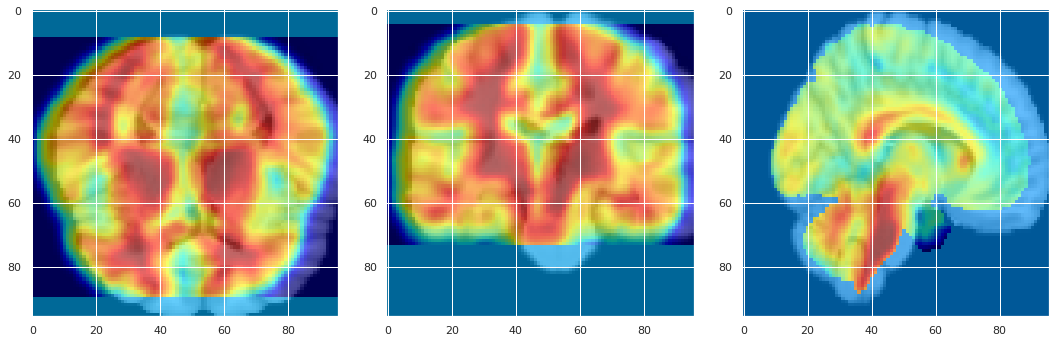

In [190]:
agree_threshold = 15
agreement = best_maps_naive_thrsh.sum(axis=0) > agree_threshold
best_maps_naive_thrsh = (best_maps_naive.copy() * agreement).sum(axis=0)
plot_vismap("template", best_maps_naive_thrsh, masked=False);

(96, 96, 96)


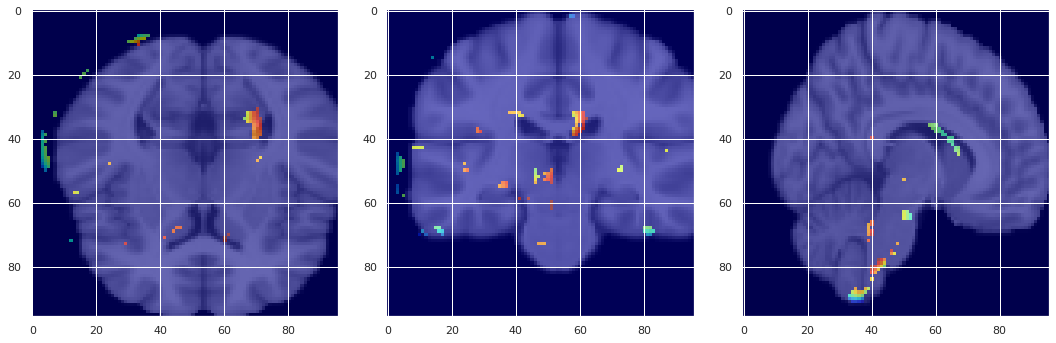

In [189]:
create_agreement(best_maps_naive, 10)

In [194]:
best_maps_naive_thrsh = best_maps_naive.copy()
for idx, npy in enumerate(best_maps_naive):
    thresholded = npy > np.quantile(npy, 0.99)
    best_maps_naive_thrsh[idx] = thresholded
# plot_vismap("template", np.mean(best_maps_naive_thrsh, axis=0), masked=False);

(array([3.465e+03, 1.511e+03, 3.470e+02, 4.000e+02, 9.000e+01, 9.900e+01,
        3.700e+01, 8.000e+00, 1.000e+01, 2.000e+00]),
 array([11. , 12.6, 14.2, 15.8, 17.4, 19. , 20.6, 22.2, 23.8, 25.4, 27. ]),
 <BarContainer object of 10 artists>)

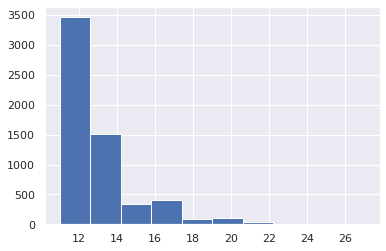

In [166]:
agreement = best_maps_naive_thrsh.sum(axis=0)
agreement = list(filter(lambda x: x > 10.0, agreement.flatten().tolist()))
plt.hist(agreement)

In [22]:
agree_threshold = 10
quantile = 0.95

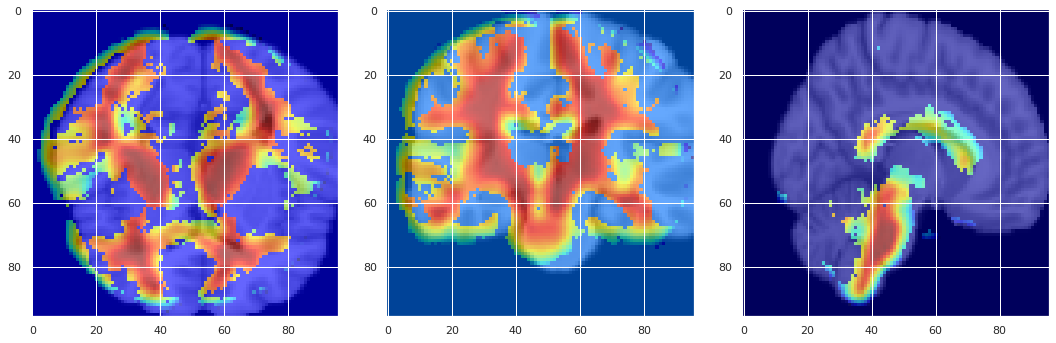

In [23]:
best_maps_naive_thrsh = best_maps_naive.copy()
for idx, npy in enumerate(best_maps_naive):
    thresholded = npy > np.quantile(npy, quantile)
    best_maps_naive_thrsh[idx] = thresholded
# plot_vismap("template", np.mean(best_maps_naive_thrsh, axis=0), masked=False);

agreement = best_maps_naive_thrsh.sum(axis=0) > agree_threshold
best_maps_naive_thrsh = (best_maps_naive.copy() * agreement).sum(axis=0)
plot_vismap("template", best_maps_naive_thrsh, masked=False);

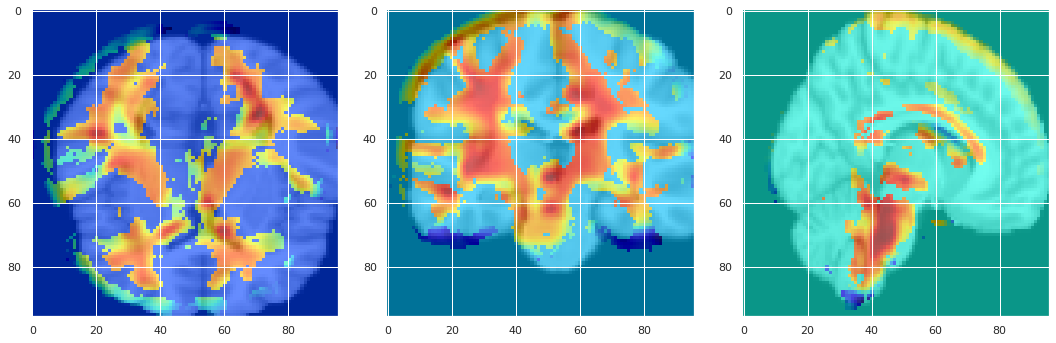

In [24]:
best_maps_augment_thrsh = best_maps_augment.copy()
for idx, npy in enumerate(best_maps_augment):
    thresholded = npy > np.quantile(npy, quantile)
    best_maps_augment_thrsh[idx] = thresholded

agreement = best_maps_augment_thrsh.sum(axis=0) > agree_threshold
best_maps_augment_thrsh = (best_maps_augment.copy() * agreement).sum(axis=0)
plot_vismap("template", best_maps_augment_thrsh, masked=False);

In [30]:
def percentile(thrsh):

    for q in [0.90, 0.95, 0.97, 0.99]:
        val = np.quantile(thrsh.flatten(), q)
        print(f"{q*100}% {val:2.5f}")
    print()


print("Naive")
percentile(best_maps_naive_thrsh)
print("Augment")
percentile(best_maps_augment_thrsh)

Naive
90.0% 16.97069
95.0% 20.57692
97.0% 21.76206
99.0% 22.94868

Augment
90.0% 12.90748
95.0% 16.74017
97.0% 18.04415
99.0% 19.47506



In [274]:
top = round((1 - quantile) * 100)
save2nifti(
    best_maps_naive_thrsh,
    f"../miccai2022/new_method/best_naive_top{top}_agree{agree_threshold}_.nii",
)
save2nifti(
    best_maps_augment_thrsh,
    f"../miccai2022/new_method/best_augment_top{top}_agree{agree_threshold}.nii",
)

Successfully saved.
Successfully saved.


(array([8.05465e+05, 5.72610e+04, 1.17380e+04, 3.99700e+03, 3.00500e+03,
        1.73700e+03, 8.47000e+02, 5.44000e+02, 1.33000e+02, 9.00000e+00]),
 array([ 0. ,  3.7,  7.4, 11.1, 14.8, 18.5, 22.2, 25.9, 29.6, 33.3, 37. ]),
 <BarContainer object of 10 artists>)

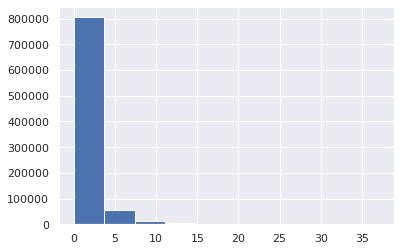

In [183]:
agreement = best_maps_augment_thrsh.sum(axis=0)
agreement = list(filter(lambda x: x > -1.0, agreement.flatten().tolist()))
plt.hist(agreement)

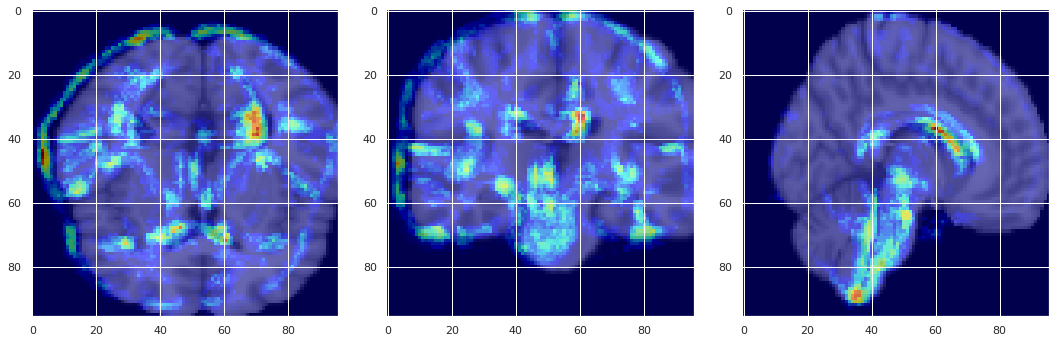

In [135]:
best_maps_naive_thrsh = best_maps_naive.copy()
for idx, npy in enumerate(best_maps_naive):
    thresholded = (npy > np.quantile(npy, 0.99)) * npy
    best_maps_naive_thrsh[idx] = thresholded
plot_vismap("template", np.mean(best_maps_naive_thrsh, axis=0), masked=False);

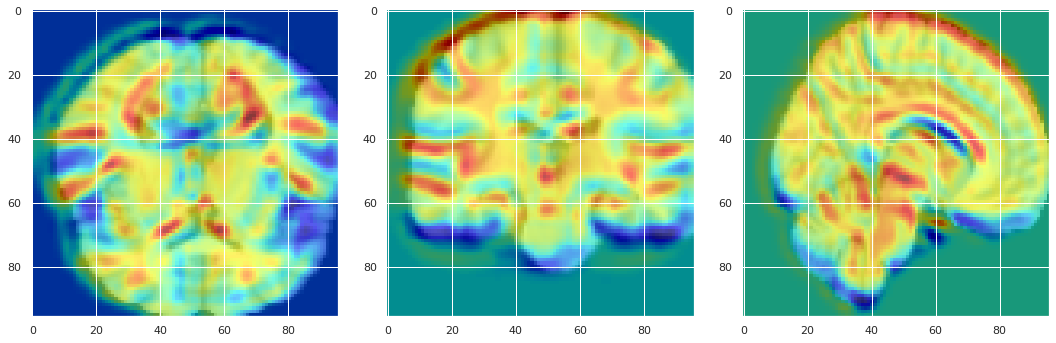

In [136]:
plot_vismap("template", np.mean(best_maps_augment, axis=0), masked=False);

In [144]:
np.quantile(np.mean(best_maps_naive, axis=0), 0.99), np.quantile(
    np.mean(best_maps_augment, axis=0), 0.99
)

(0.2110256351530552, 0.1731683239340783)

In [142]:
save2nifti(best_maps_naive, "../miccai2022/best_naive_raw.nii")
save2nifti(best_maps_augment, "../miccai2022/best_aug_raw.nii")

Came across with array dimension of 4, (100, 96, 96, 96).
Shrink with average on axis=0
Successfully saved.
Came across with array dimension of 4, (100, 96, 96, 96).
Shrink with average on axis=0
Successfully saved.


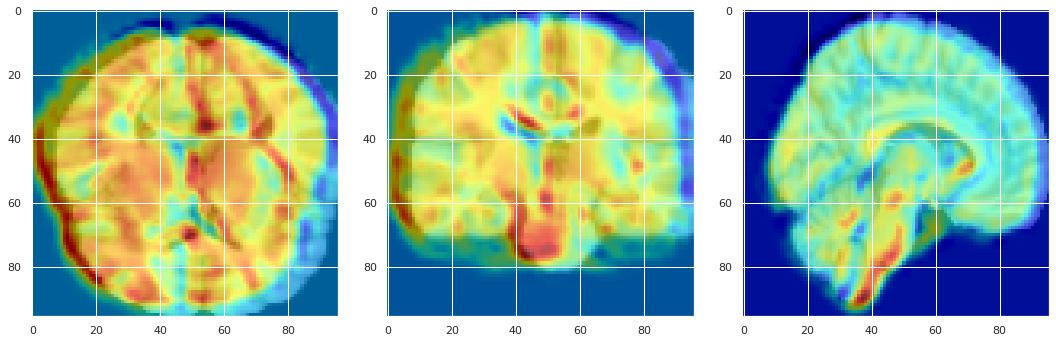

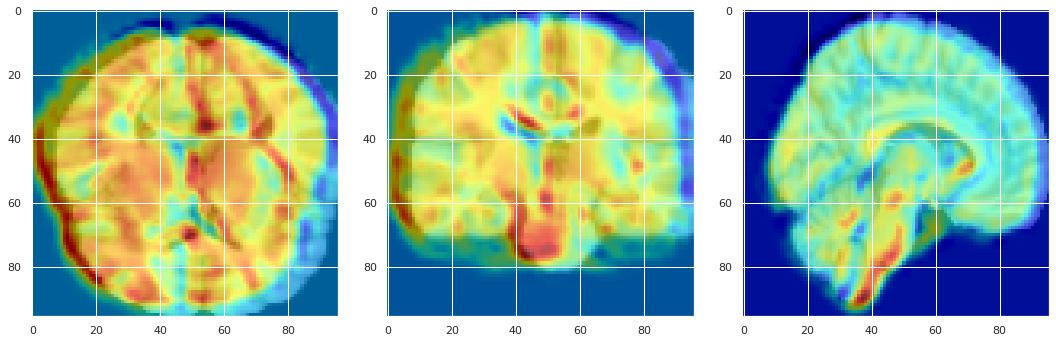

In [147]:
plot_vismap(
    "template",
    np.load(
        "../resnet256_naive_nonreg_checkpoints/20220119-2340_resnet/npy_std/layer0/ep006_mae9.92.npy"
    ),
    masked=False,
)

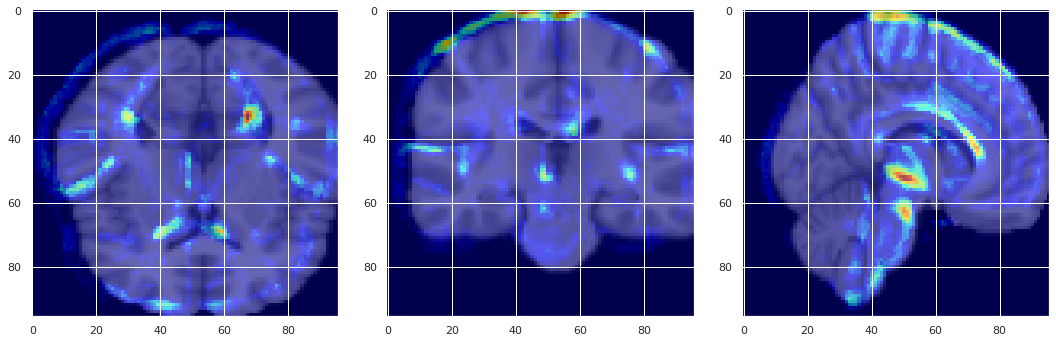

In [137]:
best_maps_augment_thrsh = best_maps_augment.copy()
for idx, npy in enumerate(best_maps_augment):
    thresholded = (npy > np.quantile(npy, 0.99)) * npy
    best_maps_augment_thrsh[idx] = thresholded
plot_vismap("template", np.mean(best_maps_augment_thrsh, axis=0), masked=False);

### Get Test data inferred

In [42]:
from utils.analysis import FileSelector, Result, MAE
import numpy as np
from functools import partial
from scipy import stats
import pickle

naive_sel = FileSelector("naive")
augment_sel = FileSelector("augment")

# naive_sel = FileSelector("naive_nonreg")
# augment_sel = FileSelector("augment_nonreg")

gt_result = np.array(naive_sel.test_gt)

In [46]:
test_reuslt = {
    naive_sel[idx][0].split("/")[2]: list(
        map(
            lambda x: (x[0], MAE(gt_result, x[1])),
            enumerate(naive_sel.get_test_result(idx).values()),
        )
    )
    for idx in range(len(naive_sel))
}

In [47]:
from glob import glob

for idx, date in enumerate(test_reuslt):
    true_epochs = len(glob(f"../resnet256_naive_checkpoints/{date}/encoder/*.pt"))
    exist_epochs = len(test_reuslt[date])
    if true_epochs == exist_epochs:
        pass
    else:
        print(idx, date)
        print(f"TRUE: {true_epochs}")
        print(f"EXIS: {exist_epochs}\n")

In [49]:
# with open("./data/naive_test_results.pkl", "wb") as f:
#     pickle.dump(test_reuslt, f)

### Test Result

In [137]:
with open("./data/naive_test_results.pkl", "rb") as f:
    naive_results = pickle.load(f)
    naive_results = {
        e[0]: e[1] for e in sorted(naive_results.items(), key=lambda x: x[0])
    }

with open("./data/augment_test_results.pkl", "rb") as f:
    augment_results = pickle.load(f)
    augment_results = {
        e[0]: e[1] for e in sorted(augment_results.items(), key=lambda x: x[0])
    }

In [51]:
with open("./data/naive_nonreg_test_results.pkl", "rb") as f:
    nonreg_naive_results = pickle.load(f)
    nonreg_naive_results = {
        e[0]: e[1] for e in sorted(nonreg_naive_results.items(), key=lambda x: x[0])
    }

with open("./data/augment_nonreg_test_results.pkl", "rb") as f:
    nonreg_augment_results = pickle.load(f)
    nonreg_augment_results = {
        e[0]: e[1] for e in sorted(nonreg_augment_results.items(), key=lambda x: x[0])
    }

In [138]:
naive = Result(naive_results)
augment = Result(augment_results)

nonreg_naive = Result(nonreg_naive_results)
nonreg_augment = Result(nonreg_augment_results)

In [49]:
# plt.figure(figsize=(12, 8))
# plt.title("Naive Training MAE Curve")
# plt.xlabel("Epoch")
# plt.ylabel("MAE")
# plt.ylim(0, 100)

# for idx in range(len(naive)):
#     plt.plot(*transform(naive[idx]), alpha=.7)

# plt.show();

In [50]:
# plt.figure(figsize=(12, 8))
# plt.title("Augment Training MAE Curve")
# plt.xlabel("Epoch")
# plt.ylabel("MAE")

# for idx in range(len(augment)):
#     plt.plot(*transform(augment[idx]))

# plt.show();

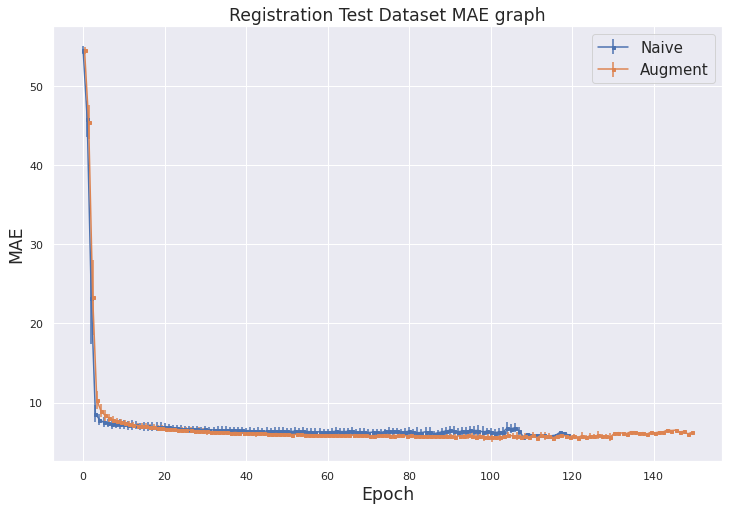

In [139]:
plt.figure(figsize=(12, 8))
plt.title("Registration Test Dataset MAE graph", size="x-large")
plt.xlabel("Epoch", size="x-large")
plt.ylabel("MAE", size="x-large")
plt.errorbar(
    *map(list, (naive.mean.keys(), naive.mean.values())),
    ms=3,
    marker="s",
    yerr=list(naive.std.values()),
    label="Naive"
)
plt.errorbar(
    np.array(list(augment.mean.keys())) + 0.35,
    list(augment.mean.values()),
    ms=3,
    marker="s",
    yerr=list(augment.std.values()),
    label="Augment",
)

# plt.errorbar(
#     *map(list, (nonreg_naive.mean.keys(), nonreg_naive.mean.values())), ms=3, marker='o',
#     yerr=list(nonreg_naive.std.values()), label="Non-Reg Naive"
# );
# plt.errorbar(
#     np.array(list(nonreg_augment.mean.keys())) + .35, list(nonreg_augment.mean.values()), ms=3, marker='o',
#     yerr=list(nonreg_augment.std.values()), label="Non-Reg Augment"
# );
plt.legend(prop={"size": 15})

In [54]:
def group_stats(naive, augment, info=None):

    if info:
        print(info)
    print(f"Naive  : {np.mean(naive):.3f} ± {np.std(naive):.3f}")
    print(f"Augment: {np.mean(augment):.3f} ± {np.std(augment):.3f}")
    t_stat, p_val = stats.ttest_ind(naive, augment)
    print(f"Statistics: {t_stat:.2f} p-value: {p_val}\n")

In [55]:
last_values_naive = [e[-1][1] for e in naive.raw_data.values()]
last_values_augment = [e[-1][1] for e in augment.raw_data.values()]

best_values_naive = [min(_[1] for _ in e) for e in naive.raw_data.values()]
best_values_augment = [min(_[1] for _ in e) for e in augment.raw_data.values()]

earlystopped_values_naive = [e[-20][1] for e in naive.raw_data.values()]
earlystopped_values_augment = [e[-20][1] for e in augment.raw_data.values()]

total_train_naive = [len(e) for e in naive.raw_data.values()]
total_train_augment = [len(e) for e in augment.raw_data.values()]

best_indices_naive = [
    sorted(e, key=lambda x: x[1])[0][0] for e in naive.raw_data.values()
]
best_indices_augment = [
    sorted(e, key=lambda x: x[1])[0][0] for e in augment.raw_data.values()
]

In [56]:
group_stats(last_values_naive, last_values_augment, "Last Value")
group_stats(best_values_naive, best_values_augment, "Best Value")
group_stats(
    earlystopped_values_naive, earlystopped_values_augment, "Early Stopped Value"
)
group_stats(total_train_naive, total_train_augment, "Total Training Epoch Value")
group_stats(best_indices_naive, best_indices_augment, "Best Indices Value")

Last Value
Naive  : 6.446 ± 0.468
Augment: 5.960 ± 0.374
Statistics: 8.11 p-value: 4.9000133813633764e-14

Best Value
Naive  : 5.935 ± 0.354
Augment: 5.657 ± 0.336
Statistics: 5.71 p-value: 4.11114005412092e-08

Early Stopped Value
Naive  : 6.523 ± 0.535
Augment: 6.108 ± 0.474
Statistics: 5.80 p-value: 2.4986330555688152e-08

Total Training Epoch Value
Naive  : 55.814 ± 19.766
Augment: 68.550 ± 21.861
Statistics: -4.32 p-value: 2.4214394200238917e-05

Best Indices Value
Naive  : 42.696 ± 16.384
Augment: 58.000 ± 18.856
Statistics: -6.13 p-value: 4.59235797283032e-09



In [55]:
del nonreg_augment.raw_data["20220125-0935_resnet"]
del nonreg_naive.raw_data["20220125-0935_resnet"]

In [56]:
last_values_naive = [e[-1][1] for e in nonreg_naive.raw_data.values()]
last_values_augment = [e[-1][1] for e in nonreg_augment.raw_data.values()]

best_values_naive = [min(_[1] for _ in e) for e in nonreg_naive.raw_data.values()]
best_values_augment = [min(_[1] for _ in e) for e in nonreg_augment.raw_data.values()]

earlystopped_values_naive = [e[-20][1] for e in nonreg_naive.raw_data.values()]
earlystopped_values_augment = [e[-20][1] for e in nonreg_augment.raw_data.values()]

total_train_naive = [len(e) for e in nonreg_naive.raw_data.values()]
total_train_augment = [len(e) for e in nonreg_augment.raw_data.values()]

best_indices_naive = [
    sorted(e, key=lambda x: x[1])[0][0] for e in nonreg_naive.raw_data.values()
]
best_indices_augment = [
    sorted(e, key=lambda x: x[1])[0][0] for e in nonreg_augment.raw_data.values()
]

In [57]:
group_stats(last_values_naive, last_values_augment, "Last Value")
group_stats(best_values_naive, best_values_augment, "Best Value")
group_stats(
    earlystopped_values_naive, earlystopped_values_augment, "Early Stopped Value"
)
group_stats(total_train_naive, total_train_augment, "Total Training Epoch Value")
group_stats(best_indices_naive, best_indices_augment, "Best Indices Value")

Last Value
Naive  : 6.680 ± 0.380
Augment: 6.680 ± 0.380
Statistics: 0.00 p-value: 1.0

Best Value
Naive  : 6.380 ± 0.364
Augment: 6.380 ± 0.364
Statistics: 0.00 p-value: 1.0

Early Stopped Value
Naive  : 6.997 ± 0.485
Augment: 6.997 ± 0.485
Statistics: 0.00 p-value: 1.0

Total Training Epoch Value
Naive  : 64.480 ± 25.111
Augment: 64.480 ± 25.111
Statistics: 0.00 p-value: 1.0

Best Indices Value
Naive  : 53.541 ± 21.881
Augment: 53.541 ± 21.881
Statistics: 0.00 p-value: 1.0



In [61]:
naive_fileselector = FileSelector("naive")
best_maps_naive = np.array(
    list(
        map(
            partial(cherry_picker, selector=naive_fileselector),
            list(
                filter(
                    partial(check_existence, selector=naive_fileselector),
                    zip(range(len(best_indices_naive)), best_indices_naive),
                )
            ),
        )
    )
)

42 46
101 88


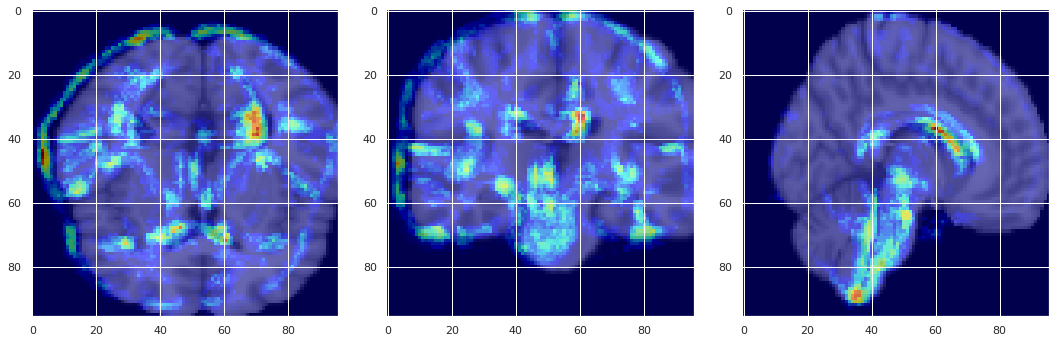

In [99]:
best_maps_naive_copy = best_maps_naive.copy()
for idx, npy in enumerate(best_maps_naive):
    thresholded = (npy > np.quantile(npy, 0.99)) * npy
    best_maps_naive_copy[idx] = thresholded

plot_vismap("template", np.mean(best_maps_naive_copy, axis=0), masked=False);

In [59]:
# SOFT SUM
augment_fileselector = FileSelector("augment")
best_maps_augment = np.array(
    list(
        map(
            partial(cherry_picker, selector=augment_fileselector),
            list(
                filter(
                    partial(check_existence, selector=augment_fileselector),
                    zip(range(len(best_indices_augment)), best_indices_augment),
                )
            ),
        )
    )
)

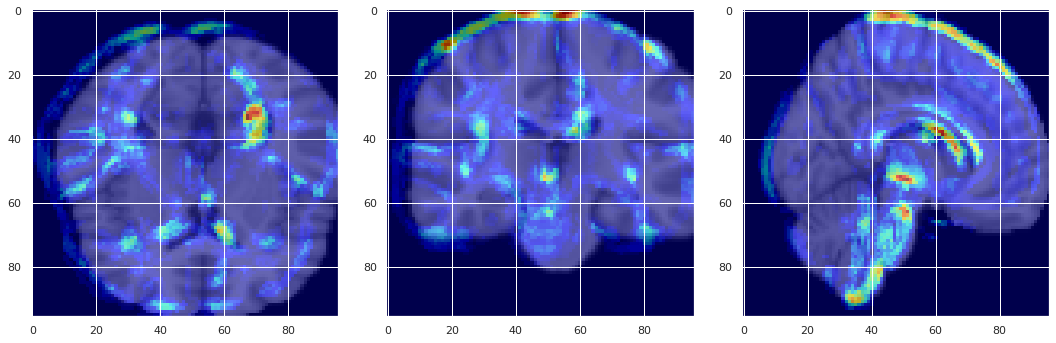

In [96]:
best_maps_augment_copy = best_maps_augment.copy()
for idx, npy in enumerate(best_maps_augment):
    thresholded = (npy > np.quantile(npy, 0.99)) * npy
    best_maps_augment_copy[idx] = thresholded

plot_vismap("template", np.mean(best_maps_augment_copy, axis=0), masked=False);

In [127]:
agree_threshold = 30
quantile = 0.95

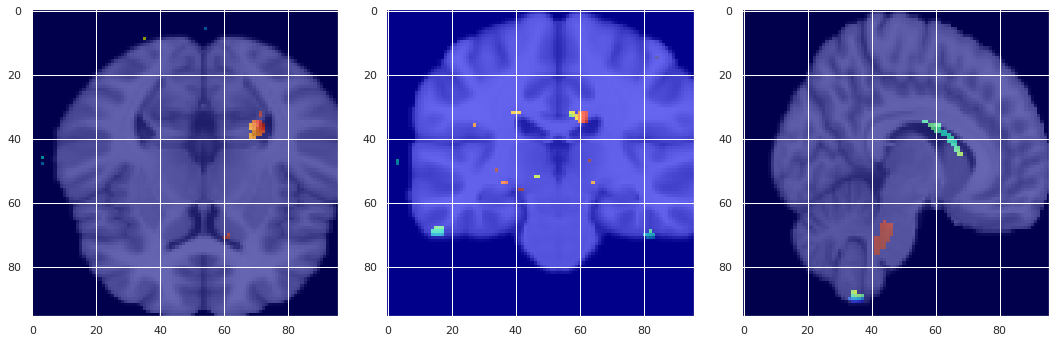

22.726793098449708 1.5080729901790655


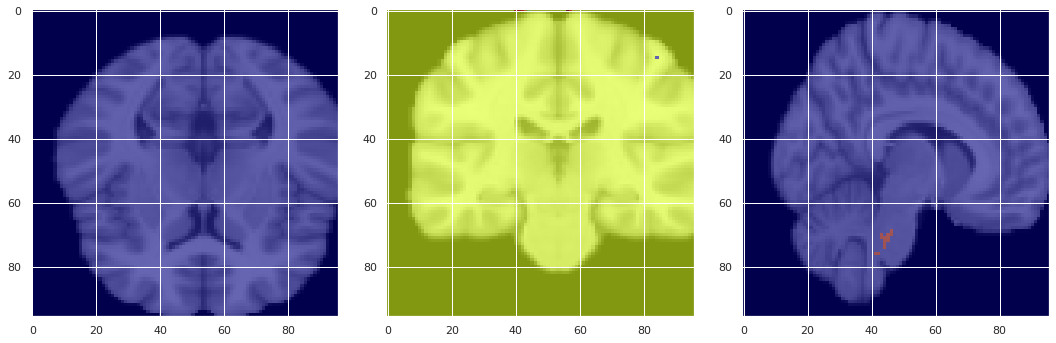

In [128]:
best_maps_naive_thrsh = best_maps_naive.copy()
for idx, npy in enumerate(best_maps_naive):
    npy = np.abs(npy)
    thresholded = npy > np.quantile(npy, quantile)
    best_maps_naive_thrsh[idx] = thresholded
# plot_vismap("template", np.mean(best_maps_naive_thrsh, axis=0), masked=False);

agreement = best_maps_naive_thrsh.sum(axis=0) > agree_threshold
best_maps_naive_thrsh = (best_maps_naive.copy() * agreement).sum(axis=0)
plot_vismap("template", best_maps_naive_thrsh, masked=False)
plot_vismap("template", both_side_quantile(best_maps_naive_thrsh, 0.95), masked=False);

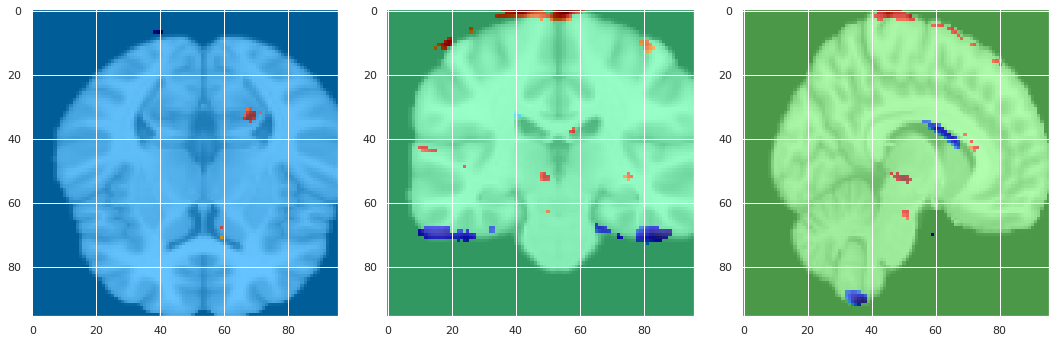

21.640104007720947 -20.343771076202394


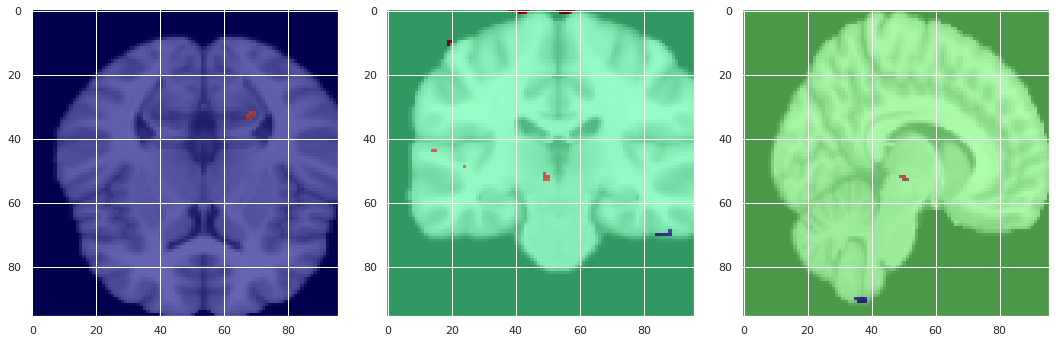

In [129]:
best_maps_augment_thrsh = best_maps_augment.copy()
for idx, npy in enumerate(best_maps_augment):
    npy = np.abs(npy)
    thresholded = npy > np.quantile(npy, quantile)
    best_maps_augment_thrsh[idx] = thresholded

agreement = best_maps_augment_thrsh.sum(axis=0) > agree_threshold
best_maps_augment_thrsh = (best_maps_augment.copy() * agreement).sum(axis=0)
plot_vismap("template", best_maps_augment_thrsh, masked=False)
plot_vismap("template", both_side_quantile(best_maps_augment_thrsh, 0.95), masked=False);

In [111]:
def both_side_quantile(thrsh, q):

    val = list(filter(lambda x: x != 0, thrsh.flatten()))
    top5 = np.quantile(val, q)
    bot5 = np.quantile(val, 1 - q)
    print(top5, bot5)
    q_bool = (thrsh > top5) | (thrsh < bot5)
    return thrsh * q_bool

In [110]:
both_side_quantile(best_maps_augment_thrsh, 0.975)

21.252798557281494 -19.335911750793457


array([[[-24.879484, -24.879484, -24.879484, ..., -24.879484,
         -24.879484, -24.879484],
        [-24.879484, -24.879484, -24.879484, ..., -24.879484,
         -24.879484, -24.879484],
        [-24.879484, -24.879484, -24.879484, ..., -24.879484,
         -24.879484, -24.879484],
        ...,
        [-24.879484, -24.879484, -24.879484, ..., -24.879484,
         -24.879484, -24.879484],
        [-24.879484, -24.879484, -24.879484, ..., -24.879484,
         -24.879484, -24.879484],
        [-24.879484, -24.879484, -24.879484, ..., -24.879484,
         -24.879484, -24.879484]],

       [[-24.879484, -24.879484, -24.879484, ..., -24.879484,
         -24.879484, -24.879484],
        [-24.879484, -24.879484, -24.879484, ..., -24.879484,
         -24.879484, -24.879484],
        [-24.879484, -24.879484, -24.879484, ..., -24.879484,
         -24.879484, -24.879484],
        ...,
        [-24.879484, -24.879484, -24.879484, ..., -24.879484,
         -24.879484, -24.879484],
        [-24

In [89]:
def hist(thrsh, bins=256):

    val = list(filter(lambda x: x != 0, thrsh.flatten()))
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.hist(val, bins=bins);

In [68]:
def percentile(thrsh):

    for q in [0.90, 0.95, 0.97, 0.99]:
        val = np.quantile(thrsh.flatten(), q)
        print(f"{q*100}% {val:2.5f}")
    print()


print("Naive")
percentile(best_maps_naive_thrsh)
print("Augment")
percentile(best_maps_augment_thrsh)

Naive
90.0% 0.00000
95.0% 0.00000
97.0% 8.04918
99.0% 16.64465

Augment
90.0% 0.00000
95.0% 0.00000
97.0% 9.27791
99.0% 16.68840



In [124]:
top = round((1 - quantile) * 100)
save2nifti(
    best_maps_naive_thrsh,
    f"../miccai2022/test_newmethod/best_naive_top{top}_agree{agree_threshold}.nii",
)
save2nifti(
    best_maps_augment_thrsh,
    f"../miccai2022/test_newmethod/best_augment_top{top}_agree{agree_threshold}.nii",
)

Successfully saved.
Successfully saved.


In [104]:
naive_nifti = np.mean(best_maps_naive_copy, axis=0)
aug_nifti = np.mean(best_maps_augment_copy, axis=0)

In [124]:
overlap = (naive_nifti > np.quantile(naive_nifti, 0.95)) & (
    aug_nifti > np.quantile(aug_nifti, 0.95)
)
overlap = overlap * (aug_nifti + naive_nifti)

In [107]:
np.quantile(naive_nifti, 0.95), np.quantile(aug_nifti, 0.95)

(0.023900355212390423, 0.02727849269285798)

In [125]:
# resized_nifti = F.interpolate(torch.tensor(nifti[None, None, ...]), size=(204, 240, 214)).squeeze().squeeze().numpy()
resized_nifti = (
    F.interpolate(torch.tensor(overlap[None, None, ...]), size=(207, 256, 215))
    .squeeze()
    .squeeze()
    .numpy()
)

In [126]:
affine = np.array(
    [
        [0.73746, 0.00000, 0.00000, -75.76254],
        [0.00000, 0.73746, 0.00000, -110.76254],
        [0.00000, 0.00000, 0.73746, -71.76254],
        [0, 0, 0, 0],
    ]
)

In [127]:
nib.save(
    nib.Nifti1Image(
        resized_nifti,
        affine,
    ),
    "../miccai2022/overlap_hard.nii",
)

In [25]:
import pandas as pd

labels = pd.read_csv("../non_registered/nifti/label.csv")

In [65]:
import nibabel as nib
import numpy as np
from tqdm import tqdm

for fname in tqdm(labels["abs_path"]):

    nifti = nib.load(fname).get_fdata()
    resized_nifti = (
        F.interpolate(torch.tensor(nifti[None, None, ...]), size=(96, 96, 96))
        .squeeze()
        .squeeze()
        .numpy()
    )
    npy_fname = fname.replace("nifti", "npy").replace(".nii", ".npy")
    np.save(npy_fname, resized_nifti)
    # break

100%|██████████| 1452/1452 [06:59<00:00,  3.46it/s] 


In [32]:
from scipy import stats

In [34]:
resized_nifti = np.resize(nifti, (96, 96, 96))

In [43]:
import torch
import torch.nn.functional as F

In [50]:
resized_nifti = (
    F.interpolate(torch.tensor(nifti[None, None, ...]), size=(96, 96, 96))
    .squeeze()
    .squeeze()
    .numpy()
)

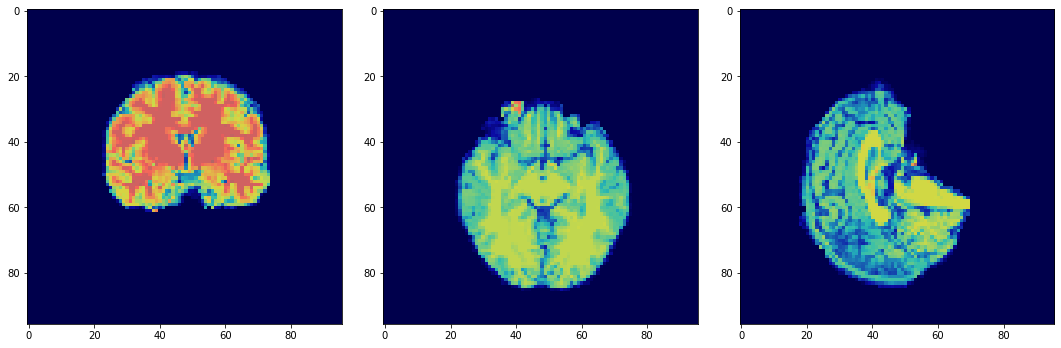

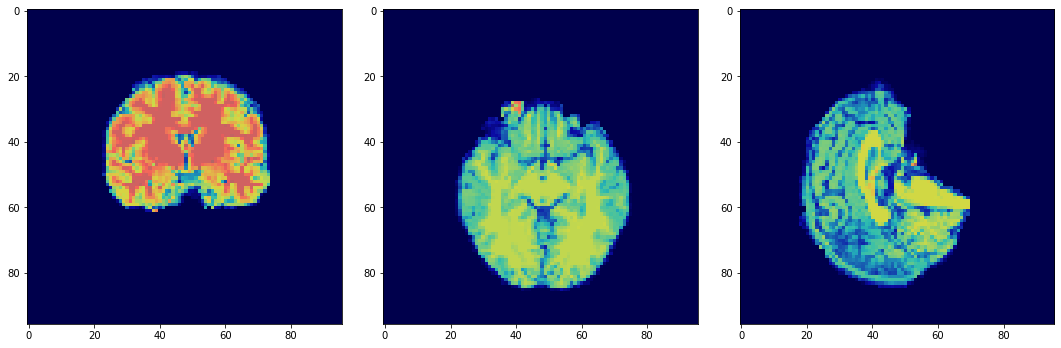

In [52]:
plot_vismap(
    resized_nifti,
    resized_nifti,
    masked=False,
)

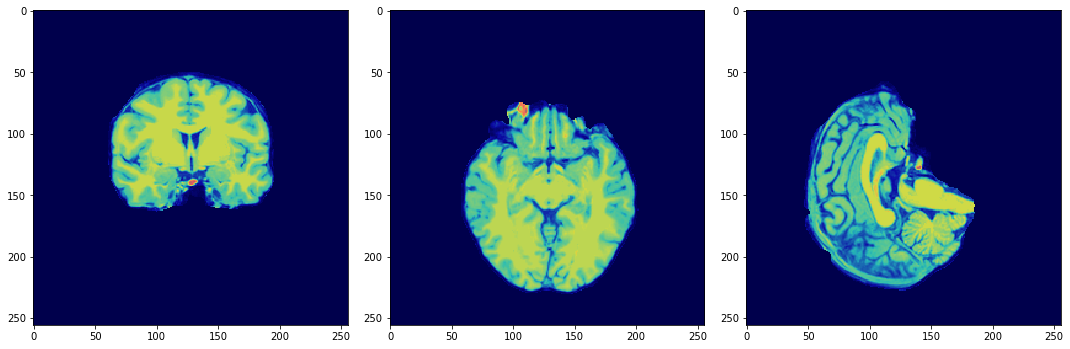

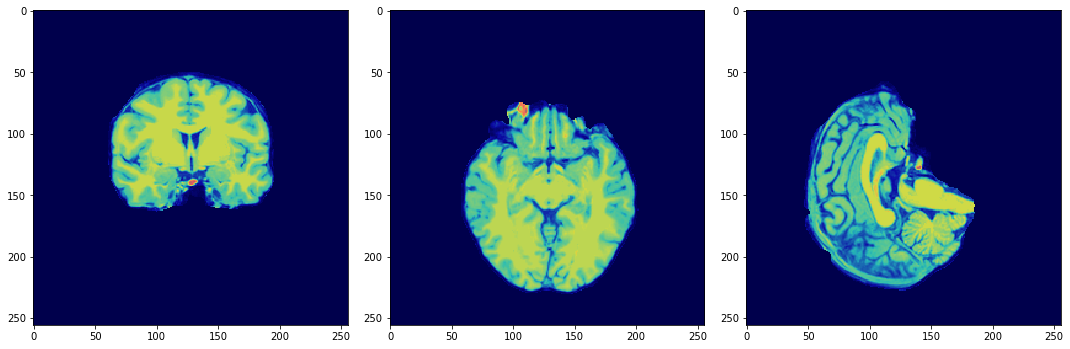

In [53]:
plot_vismap(nifti, nifti, slc=128, masked=False)

In [23]:
from scipy import resize
import numpy as np
from glob import glob

for fname in glob("../non_registered/npy/*.npy"):

    origin = np.load(fname, allow_pickle=True)
    if origin.shape == (96, 96, 96):
        pass
    else:
        resized = resize(origin, (96, 96, 96))
        np.save(fname, resized)

OSError: Failed to interpret file '../non_registered/npy/sub-OAS30852_ses-d2307_run-04_T1w.npy-brainmask.npy' as a pickle

In [13]:
type(_)

numpy.ndarray

In [59]:
from glob import glob
import numpy as np

np.load(glob("../non_registered/npy/*.npy")[0])

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [25]:
labels.to_csv("../non_registered/nifti/label.csv", index=False)

In [1]:
from sage.training.trainer import MRITrainer
from sage.config import load_config

cfg = load_config()

cfg.registration = "non_registered"

In [2]:
trainer = MRITrainer(cfg)

Use cuda:0 as a device.


[01/19/2022 18:25:41] INFO - sage.data.dataloader: Initialize dataset.
[01/19/2022 18:25:41] INFO - sage.data.dataloader: Initialize dataset.
[01/19/2022 18:25:41] INFO - sage.data.dataloader: Initialize dataset.


Output from encoder is 128.
Total Number of parameters: 905549
TOTAL TRAIN 1044 | VALID 262 | TEST 146
MIXED PRECISION:: True


In [4]:
batch = _

In [11]:
trainer.test_dataloader.dataset.configuration()[1].maxcut is None

True

In [61]:
import numpy as np
from sage.visualization.vistool import plot_vismap
from glob import glob
import matplotlib.pyplot as plt

sample_np_nonreg = np.load(sorted(glob("../non_registered/npy/*.npy"))[0])

In [60]:
sample_np = np.load(sorted(glob("../brainmask_mni/*.npy"))[0])

In [21]:
sample_np.dtype

dtype('float32')

In [20]:
sample_np_nonreg.dtype

dtype('float64')

(array([     0.,      0.,      0.,      0.,      0., 884736.,      0.,
             0.,      0.,      0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

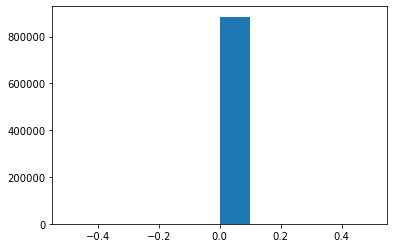

In [12]:
plt.hist(sample_np.flatten())

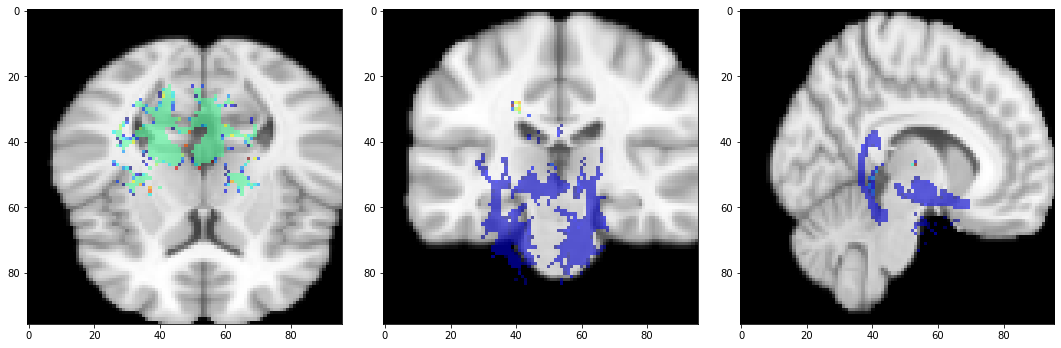

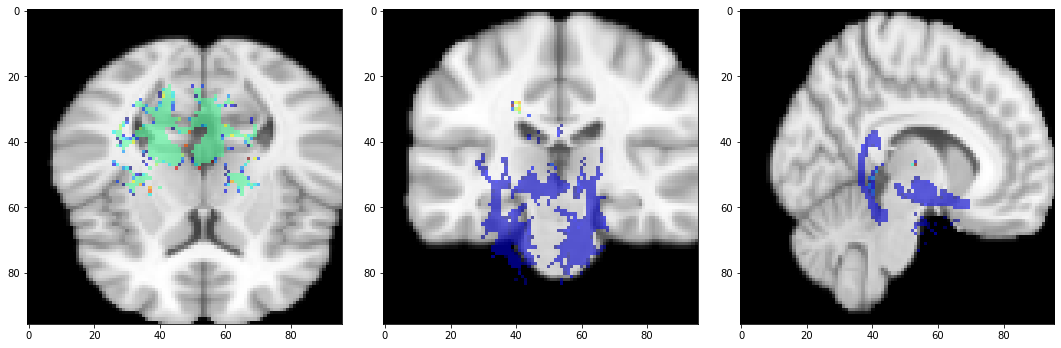

In [63]:
plot_vismap("template", sample_np_nonreg)